# Lecture #6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pickle

%matplotlib inline

For this lecture, we are going to be using [these](http://www.stat.cmu.edu/~cshalizi/350-2006/lecture-10.pdf) lecture notes from a Data Mining course by Cosma Shalizi (a CMU Stats professor). Be sure to read through them first...

Let's start by creating at a very basic dataset with two features and two possible values (-1 and 1).

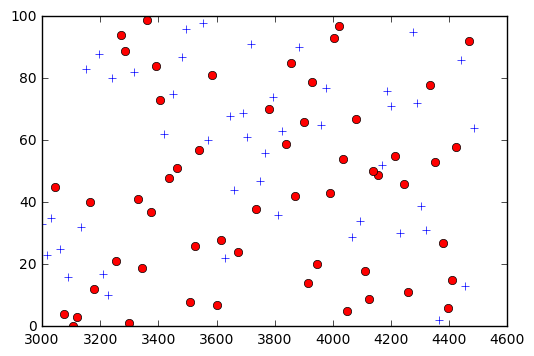

In [2]:
d = {'Value': np.random.binomial(1, 0.5,size=(100,))*2-1,
                  'x1' : np.random.permutation(100)*15+3000,
                  'x2' : np.random.permutation(100)}
df = pd.DataFrame(d)

plt.plot(df[df.Value>0].x1,df[df.Value>0].x2, 'b+')
plt.plot(df[df.Value<=0].x1,df[df.Value<=0].x2, 'ro')
plt.show()

It would clearly be difficult to find a classifier (even as robust as a decision tree) to find a decision boundary that can separate out -1s (reds) from +1s (blues). This should be reflected in the objective function that is optimized for training the model (i.e., finding the right partitioning of the input space).

Let's see how that goes...

First, let's define the funciton $S$ (shown on page 5 of the PDF), and let's have it calculate the sum of squared errors for all leaves at a node. As input, it will take the dataset that will go trhough that node of the tree (```d```), the feature we would like to use for splitting (```f```) and the threshold (```t```):

In [3]:
def S(d,f,t):
    left = d[d[f]>t]['Value']
    right = d[d[f]<=t]['Value']

    S_left = np.sum((left-np.mean(left))**2)
    S_right = np.sum((right-np.mean(right))**2)

    return S_left + S_right

Now let's put it to use to check which variable we should split first:

Looks like we should split x2 at 59


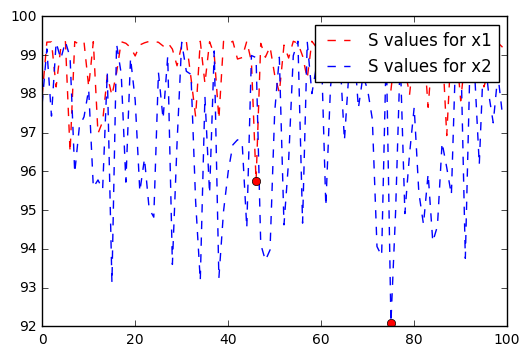

In [4]:
x1thresholds = df.x1.unique() # These are the x1 thresholds
x2thresholds = df.x2.unique() # These are the x2 thresholds

# Let's list all possible thresholds and calculate their S value:
Sx1 = [S(df,'x1',t) for t in x1thresholds]
Sx2 = [S(df,'x2',t) for t in x2thresholds]

plt.plot(Sx1,'r--')
plt.plot(Sx2,'b--')

x1t = x1thresholds[np.argmin(Sx1)]
x2t = x2thresholds[np.argmin(Sx2)]

Sx1min = np.min(Sx1)
Sx2min = np.min(Sx2)

plt.plot(np.argmin(Sx1), Sx1min,'or')
plt.plot(np.argmin(Sx2), Sx2min,'or')
plt.legend(['S values for x1', 'S values for x2'])

if Sx2min > Sx1min:
    print("Looks like we should split x1 at {}".format(x1t))
else:
    print("Looks like we should split x2 at {}".format(x2t))
        
plt.show()


So, definitely the output of S over all possible thresholds for each variable is very non-smooth, but the list of all possible thresholds is not that long so we can easily solve it. 

So we go ahead and make the split... Two new filtered datasets:

In [5]:
branch1 = df[df.x1>x1t]
branch2 = df[df.x1<=x1t]

... and you can go from there to repeat the process. But I'm tired.

So we are going to try it out with ```sklearn``` (scikit-learn):

In [6]:
from sklearn import tree

In [7]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(df[['x1','x2']], df['Value'])

In terms of training the model (i.e. fitting the tree) we are done. Nothing else to do. The object ```clf``` (classifier) is a tree and it has been trained. We can now call its methods to do fancy things:

In [8]:
# Let's look at the importance of the features 
# (this is called a Gini importance metric)
print(clf.feature_importances_)

[ 0.45769768  0.54230232]


In [9]:
# Let's see how well it scores when feeding it the same dataset it was trained on:
clf.score(df[['x1','x2']], df['Value'])

1.0

It got a perfect score! How can that be? That tree must be really deep.
Can we visualize it? 
I took some code from [here](http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html#sphx-glr-auto-examples-tree-plot-iris-py) and tweaked it to do just that:

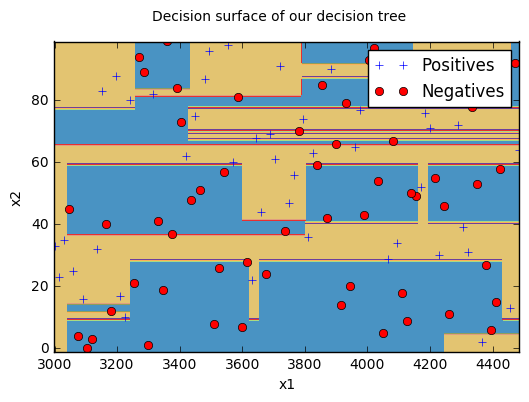

In [10]:
plot_step = 1

X = df[['x1','x2']]
y = df['Value']

# Let's pre-compute the range for our features
x_min, x_max = X['x1'].min() - 1, X['x1'].max() + 1
y_min, y_max = X['x2'].min() - 1, X['x2'].max() + 1
# And create a meshgrid so that we can create a countour plot on it
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

# Now we predict the values for all of the cells in the meshgrid
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) # If you're curious what this is, read here: https://docs.scipy.org/doc/numpy/reference/generated/numpy.c_.html and https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html
# And we reshape those results to have the same shape as the mesh
Z = Z.reshape(xx.shape)
# Now we can finally contour-plot, using a specific colormap
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

# Let's add labels to the axes
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis("tight")

# Plot the training points
plt.plot(df[df.Value>0].x1,df[df.Value>0].x2, 'b+')
plt.plot(df[df.Value<=0].x1,df[df.Value<=0].x2, 'ro')
plt.axis("tight")

# And add a few more beautification items
plt.suptitle("Decision surface of our decision tree")
plt.legend(['Positives','Negatives'])
plt.show()


Now let's try a regression task. To begin, let's use an existing dataset.

In [99]:
from sklearn.datasets import load_boston

print(load_boston().DESCR)

df = pd.DataFrame(
        data=np.column_stack((load_boston().data,load_boston().target)),
        columns=np.append(load_boston().feature_names,['Median_Value'])
    )

df.describe()

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Median_Value
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Now let's pick just two of those variables to do a simple regression:

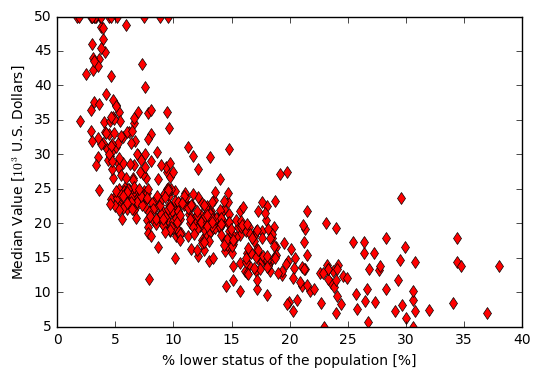

In [105]:
def plot_regdata():
    plt.plot(df['LSTAT'],df['Median_Value'],'rd')
    plt.xlabel('% lower status of the population [%]')
    plt.ylabel('Median Value [$10^3$ U.S. Dollars]')

plot_regdata()
plt.show()

Now we can fit a regression tree on these two variables:

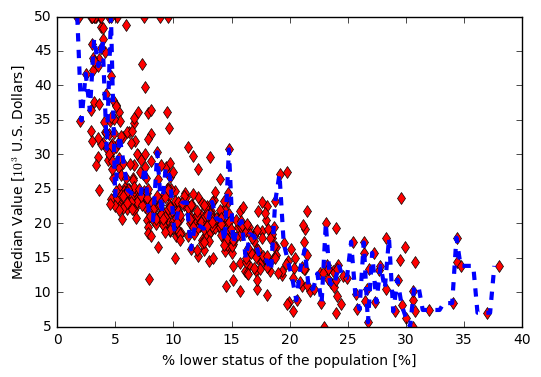

In [192]:
x = df[['LSTAT']]
y = df[['Median_Value']]
xrange = np.arange(x.min(),x.max(),(x.max()-x.min())/100).reshape(100,1)

reg = tree.DecisionTreeRegressor() # Default parameters, though you can tweak these!
reg.fit(x,y)

plot_regdata()
plt.plot(xrange,reg.predict(xrange),'b--',linewidth=3)
plt.show()

So there you go, we fit a regression tree and it produced a very non-linear and non-smooth response over the feature 'LSTAT'. How well does it work? Let's test its score:

In [194]:
print(reg.score(x,y)) # Check out the documentation for the score method, to make sure you understand what it means.


0.959008812687


Clearly, though, this does not mean that using one single variable (% Lower Status of the Population, in this case) can explain 95% of the variance in the Median Value of a house in Boston. More likely, we have overfitted our model to the data. We haven't covered overfitting yet, or ways to prevent it, but can you think of ways to achieve a more balanced model fit?